## Importing the libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import os

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix,classification_report

## Loading the image data set

In [3]:
def data_load():
    X=[]
    dir_path="/Users/bhuvaneshmarineni/ODU subject related/Computer Vision/dataset/train"
    for sub_dir in tqdm(os.listdir(dir_path)):
        path_main=os.path.join(dir_path,sub_dir)
        i=0
        for img_name in os.listdir(path_main):
            if i>=6:
                break
            img=cv2.imread(os.path.join(path_main,img_name))
            img=cv2.resize(img,(224,224))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            X.append(img)
            i+=1
    return X

In [6]:
print("Loading data...")
arr_img = np.array(data_load())
print("Data loaded successfully!")
print("Array shape:", arr_img.shape)


Loading data...


 14%|█▍        | 1/7 [00:00<00:00, 33.36it/s]


NotADirectoryError: [Errno 20] Not a directory: '/Users/bhuvaneshmarineni/ODU subject related/Computer Vision/dataset/train/.DS_Store'

In [5]:
arr_img=np.array(data_load())
arr_img.shape

 14%|█▍        | 1/7 [00:00<00:00, 37.17it/s]


NotADirectoryError: [Errno 20] Not a directory: '/Users/bhuvaneshmarineni/ODU subject related/Computer Vision/dataset/train/.DS_Store'

## Visualizing the images

In [7]:
def img_disp(X):
    if X.shape[0]==36:
        f, ax= plt.subplots(6,6, figsize=(40,60))
        list_fruits=['rottenbanana','freshoranges','rottenoranges', 'freshbanana', 'rottenapples',   'freshapples']
        for i,img in enumerate(X):
            ax[i//6][i%6].imshow(img, aspect='auto')
            ax[i//6][i%6].set_title(list_fruits[i//6])
        plt.show()
    else:
        print('Cannot plot')

In [8]:
img_disp(arr_img)


NameError: name 'arr_img' is not defined

## Generating the training and test datasets

In [20]:
train_dir = "/Users/bhuvaneshmarineni/ODU subject related/Computer Vision/dataset/dataset/train"
test_dir = "/Users/bhuvaneshmarineni/ODU subject related/Computer Vision/dataset/dataset/test"

# Train Dataset
train_dir = "/Users/bhuvaneshmarineni/ODU subject related/Computer Vision/dataset/dataset/train"
#fresh 
apple_freshTr = os.path.join(train_dir, 'freshapples') 
banana_freshTr = os.path.join(train_dir, 'freshbanana')
orange_freshTr = os.path.join(train_dir, 'freshoranges')

#rotten
apple_rotTr = os.path.join(train_dir, 'rottenapples')
banana_rotTr = os.path.join(train_dir, 'rottenbanana')
orange_rotTr = os.path.join(train_dir, 'rottenoranges')


# Test Dataset
test_dir = "/Users/bhuvaneshmarineni/ODU subject related/Computer Vision/dataset/dataset/test"
#fresh
apple_freshTe = os.path.join(test_dir, 'freshapples')
banana_freshTe = os.path.join(test_dir, 'freshbanana')
orange_freshTe = os.path.join(test_dir, 'freshoranges')

#rotten
apple_rotTe = os.path.join(test_dir, 'rottenapples')
banana_rotTe = os.path.join(test_dir, 'rottenbanana')
orange_rotTe = os.path.join(test_dir, 'rottenoranges')

apple_freshTr_len=len(os.listdir(apple_freshTr))
banana_freshTr_len=len(os.listdir(banana_freshTr))
orange_freshTr_len=len(os.listdir(orange_freshTr))
apple_rotTr_len=len(os.listdir(apple_rotTr))
banana_rotTr_len=len(os.listdir(banana_rotTr))
orange_rotTr_len=len(os.listdir(orange_rotTr))


labels = os.listdir("/Users/bhuvaneshmarineni/ODU subject related/Computer Vision/dataset/dataset/train")
print("Classes names:")
print(".............")
labels

Classes names:
.............


['freshbanana',
 'rottenbanana',
 'freshoranges',
 'freshapples',
 'rottenoranges',
 'rottenapples']

In [21]:
datagen = ImageDataGenerator( 
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True,
  vertical_flip=True,
  rescale=1./255,                           
  preprocessing_function=keras.applications.vgg16.preprocess_input
  )

datagen1 = ImageDataGenerator(
  rescale=1./255,                           
  preprocessing_function=keras.applications.vgg16.preprocess_input
  )

In [22]:
train_gen = datagen.flow_from_directory(train_dir, 
                                       target_size=[224,224],
                                       color_mode='rgb', 
                                       class_mode="categorical", 
                                       batch_size = 32, 
                                       shuffle=True) 
val_gen = datagen1.flow_from_directory(test_dir, 
                                       target_size=[224,224],
                                       color_mode='rgb', 
                                       class_mode="categorical",
                                       batch_size = 32,
                                       shuffle=True) 

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [23]:
train_gen.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [24]:
val_gen.class_indices


{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

## Developing the model for image classification

In [25]:
def DL_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
  
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    
    top_model = GlobalAveragePooling2D()(top_model)

    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (224, 224, 3)
n_classes=6

vgg_model = DL_model(input_shape, n_classes, fine_tune=0)

58889256/58889256 [==============================] - 1s 0us/step


In [26]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
checkpoint_filepath = 'vgg16_model_best_weights.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
vgg_history = vgg_model.fit(train_gen,validation_data=val_gen,
          steps_per_epoch=train_gen.samples/train_gen.batch_size, 
          validation_steps=val_gen.samples/val_gen.batch_size, 
          epochs=5,callbacks=[checkpoint])

Epoch 1/5


2023-04-04 14:21:12.945555: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


341/340 [==============================] - ETA: 0s - loss: 1.1391 - accuracy: 0.6883

KeyboardInterrupt: 

## Visualizing the performance of the model

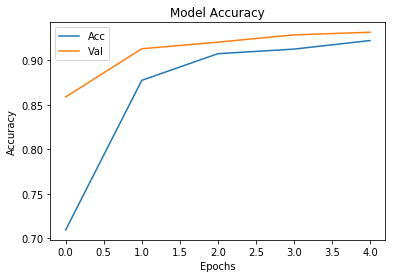

In [35]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Acc','Val'], loc = 'upper left')

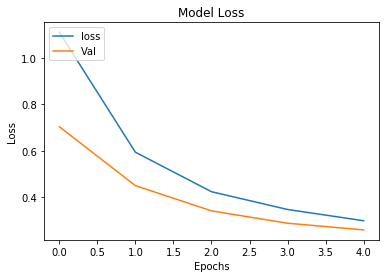

In [36]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','Val'], loc = 'upper left')

In [ ]:
model = DL_model(input_shape=(224, 224, 3), n_classes=6)
model.load_weights('vgg16_model_best_weights.h5')

# Load and preprocess the image
img_path = '/Users/bhuvaneshmarineni/ODU subject related/Computer Vision/apple.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = keras.applications.vgg16.preprocess_input(x)

# Make predictions on the input image
preds = model.predict(x)
classes = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
result = classes[np.argmax(preds)]

# Check if the fruit is fresh or rotten
if 'fresh' in result:
    print('The fruit is fresh')
else:
    print('The fruit is rotten')